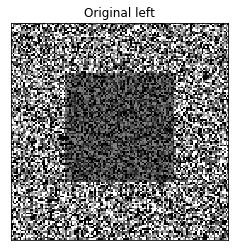

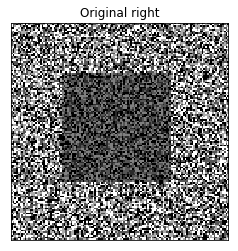

In [2]:
import cv2
import numpy as np
import sys
from matplotlib import pyplot as plt




left = cv2.imread('Data\\leftTest.png',0)
right = cv2.imread('Data\\rightTest.png',0)


plt.imshow(left,cmap='gray')
plt.title('Original left'), plt.xticks([]), plt.yticks([])
plt.show()


plt.imshow(right,cmap='gray')
plt.title('Original right'), plt.xticks([]), plt.yticks([])
plt.show()

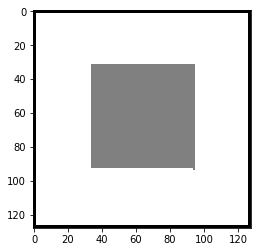

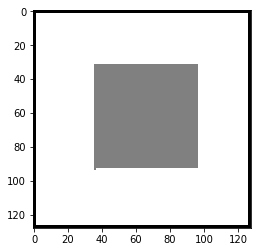

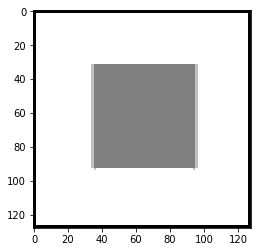

In [48]:
def SSD(template,other,i,j,offset,winSizeHalf):
    result=0
    for i2 in range(-winSizeHalf,winSizeHalf):
        for j2 in range(-winSizeHalf,winSizeHalf):
            result+=(int(template[j+j2,i+i2])-int(other[j+j2,i+i2-offset]))**2
    return result

def stereoLeftToRight(left,right,winSize):
    height, width = left.shape
    dTab=np.zeros((width,height))    
    winSizeHalf=int(winSize/2)
    dmin=1
    dmax=2
    disp=np.zeros((width,height,dmax+1-dmin))
    for i in range(winSizeHalf,width-winSizeHalf):
        for j in range(winSizeHalf,height-winSizeHalf):
            for d in range(dmin,dmax+1-dmin):
                disp[j,i,d]=SSD(left,right,i,j,d+dmin,winSizeHalf)
            dTab[j,i]=np.argmax(disp[j,i,:])+dmin
    return dTab

def stereo(left,right,winSize):
    dTab=stereoLeftToRight(left,right,winSize)
    imgplot = plt.imshow(dTab,cmap='gray')
    plt.title('1) a. Dleft'), plt.xticks([]), plt.yticks([])
    plt.show()
    dTab2=stereoLeftToRight(cv2.flip(right, flipCode=1),cv2.flip(left, flipCode=1),winSize)
    #dTab2=cv2.flip(dTab2, flipCode=1)
    imgplot = plt.imshow(dTab2,cmap='gray')
    plt.show()

            
stereo(left,right,5)  